# Code for plots in the directional filter paper

#### Importing

In [2]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from cycler import cycler
from sympy import symbols, I, cos, sin, re, im, Abs, lambdify, simplify, expand
from sympy import *

from filterbank.components import Filterbank, TransmissionLine, ManifoldFilter, DirectionalFilter, BaseFilter

plt.style.use('~/Repos/louis-style-docs/default.mplstyle')

fig_path = "./figures/"


#### Settings

In [3]:
nF = int(2e4)
f = np.linspace(210e9,450e9,nF)

f0_single = 330e9

f0_min = 220e9
f0_max = 440e9

## Variances
sigma_Qc = 0.04 #0.10
sigma_f0 = 0. #0.085


Z0_res = 50.6
eps_eff_res = 28.8
Qi_res = 1800


Z0_thru = 80.4
eps_eff_thru = 29.7

TL_thru = TransmissionLine(Z0_thru,eps_eff_thru)

TL_res = TransmissionLine(Z0_res,eps_eff_res,Qi=np.inf)
TL_res_lossy = TransmissionLine(Z0_res,eps_eff_res,Qi=Qi_res)

TransmissionLinesDict = {
    'through' : TL_thru,
    'resonator' : TL_res,
    'MKID' : TL_thru
}

TransmissionLinesLossyDict = {
    'through' : TL_thru,
    'resonator' : TL_res_lossy,
    'MKID' : TL_thru
}



#### Generate numerical models

In [4]:
#-----------------------------
single_filter_MF = ManifoldFilter(
    f0=f0_single,
    Ql=500,
    TransmissionLines=TransmissionLinesDict,
    compensate=False
)
single_filter_MF.S(f)
single_filter_MF.realized_parameters()

single_filter_DF = DirectionalFilter(
    f0=f0_single,
    Ql=500,
    TransmissionLines=TransmissionLinesDict,
    compensate=False
)
single_filter_DF.S(f)
single_filter_DF.realized_parameters()
#-----------------------------



#-----------------------------
## Manifold filter, no variance
FB_MF_no_variance = Filterbank(
    FilterClass=ManifoldFilter,
    TransmissionLines=TransmissionLinesDict,
    f0_min=f0_min,
    f0_max=f0_max,
    Ql=500,
    oversampling=1,
    sigma_f0=0,
    sigma_Qc=0,
    compensate=False
)
FB_MF_no_variance.S(f)
FB_MF_no_variance.realized_parameters()

## Manifold filter, variance
FB_MF_variance = Filterbank(
    FilterClass=ManifoldFilter,
    TransmissionLines=TransmissionLinesLossyDict,
    f0_min=f0_min,
    f0_max=f0_max,
    Ql=500,
    oversampling=1,
    sigma_f0=sigma_f0,
    sigma_Qc=sigma_Qc,
    compensate=False
)
FB_MF_variance.S(f)
FB_MF_variance.realized_parameters()
#-----------------------------



#-----------------------------
## Directional filter, no variance
FB_DF_no_variance = Filterbank(
    FilterClass=DirectionalFilter,
    TransmissionLines=TransmissionLinesDict,
    f0_min=f0_min,
    f0_max=f0_max,
    Ql=500,
    oversampling=1,
    sigma_f0=0,
    sigma_Qc=0,
    compensate=False
)
FB_DF_no_variance.S(f)
FB_DF_no_variance.realized_parameters()

## Directional filter, variance
FB_DF_variance = Filterbank(
    FilterClass=DirectionalFilter,
    TransmissionLines=TransmissionLinesLossyDict,
    f0_min=f0_min,
    f0_max=f0_max,
    Ql=500,
    oversampling=1,
    sigma_f0=sigma_f0,
    sigma_Qc=sigma_Qc,
    compensate=False
)
FB_DF_variance.S(f)
FB_DF_variance.realized_parameters()
#-----------------------------

(array([4.39151373e+11, 4.38155370e+11, 4.37207368e+11, 4.36487366e+11,
        4.35539364e+11, 4.34735362e+11, 4.33919360e+11, 4.33127358e+11,
        4.32275356e+11, 4.31159353e+11, 4.30355351e+11, 4.29455349e+11,
        4.28542746e+11, 4.27846745e+11, 4.27054743e+11, 4.26070740e+11,
        4.25122738e+11, 4.24426736e+11, 4.23550734e+11, 4.22722732e+11,
        4.21834730e+11, 4.21114128e+11, 4.20346126e+11, 4.19230123e+11,
        4.18282721e+11, 4.17730119e+11, 4.17034718e+11, 4.16194115e+11,
        4.15234113e+11, 4.14466111e+11, 4.13530109e+11, 4.12786107e+11,
        4.11934105e+11, 4.11130103e+11, 4.10098100e+11, 4.09294098e+11,
        4.08646097e+11, 4.07901495e+11, 4.06941492e+11, 4.06102090e+11,
        4.05465489e+11, 4.04613487e+11, 4.03653484e+11, 4.02945482e+11,
        4.02333481e+11, 4.01385478e+11, 4.00510076e+11, 3.99777474e+11,
        3.98889472e+11, 3.98229471e+11, 3.97557469e+11, 3.96573466e+11,
        3.95601464e+11, 3.94893462e+11, 3.94149460e+11, 3.934294

#### Analytical model

In [25]:
c = 3e8

f0 = single_filter_DF.f0
eps_eff = single_filter_DF.Resonator1.TransmissionLine.eps_eff
l_res = single_filter_DF.Resonator1.l_res
cap = single_filter_DF.Resonator1.Coupler1.C
Z0 = single_filter_DF.Resonator1.TransmissionLine.Z0
ZR = single_filter_DF.Resonator1.Z_termination[0]

lambda0 = c / f0 / np.sqrt(eps_eff)


### Analytical model part
omega, C, Y0, YR, bet, l, freq, dummy = symbols('omega C Y0 YR beta l freq dummy')



denominator = (2 - 4*I * Y0/(omega * C)) * cos(bet*l) + (2* YR / (omega * C) + 1*I * (YR / Y0 + 2 * Y0 / YR - 2 * Y0 * YR / ((omega * C)**2))) * sin(bet*l)

# f0 = 270e9
# k0 = 2 * np.pi * f0 / c
# lambda0 = c / f0

# Z0 = 60
# ZR = 80

# cap = capacitance(f0,100,Z0,ZR)

substitutions = [
    (omega,2 * np.pi * freq),
    (C,cap),
    (Y0,1/Z0),
    (YR,1/ZR),
    (bet,2 * np.pi * freq * np.sqrt(eps_eff) / c),
    (l,l_res),
    (dummy,1e-6)
]

B1 = ((-1*I * YR/Y0) * sin(bet*l)) / denominator
S11_func = lambdify(freq, Abs(B1.subs(substitutions))**2, "numpy")

B2 = ((-4* Y0 / (omega * C)) * cos(bet*l) + 2 * (Y0/YR - YR * Y0/((omega*C)**2)) * sin(bet*l) ) / denominator
S21_func = lambdify(freq, Abs(B2.subs(substitutions))**2, "numpy")

B3 = 2 / denominator
S31_func = lambdify(freq, Abs(B3.subs(substitutions))**2, "numpy")

B4 = dummy * freq / (freq - dummy)
S41_func = lambdify(freq, Abs(B4.subs(substitutions))**2, "numpy")

#### Plotting functions

In [6]:
from matplotlib.collections import PatchCollection

# define an object that will be used by the legend
class MulticolorPatch(object):
    def __init__(self, colors):
        self.colors = colors
        
# define a handler for the MulticolorPatch object
class MulticolorPatchHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        width, height = handlebox.width, handlebox.height
        patches = []
        for i, c in enumerate(orig_handle.colors):
            patches.append(plt.Rectangle([width/len(orig_handle.colors) * i - handlebox.xdescent, 
                                          -handlebox.ydescent],
                           width / len(orig_handle.colors),
                           height, 
                           facecolor=c, 
                           edgecolor='none'))

        patch = PatchCollection(patches,match_original=True)

        handlebox.add_artist(patch)
        return patch


def plot_centered():
    plot = plt.gcf()
    return plot.add_axes([0.18,0.15,0.64,0.75])

def plotstep_add_S_params(f, Filter: BaseFilter,ax: plt.Axes=None):
    if ax == None:
        ax = plt.gca()

    S_param_list = [
        Filter.S11_absSq,
        Filter.S21_absSq,
        Filter.S31_absSq
    ]

    if Filter.S41_absSq is not None:
        S_param_list.append(Filter.S41_absSq)

    return [line for Sii in S_param_list for line in ax.plot(f/1e9, Sii)]

def plotstep_add_analytical_model(f,ax: plt.Axes=None):
    if ax == None:
        ax = plt.gca()

    S_param_list = [
        S11_func(f),
        S21_func(f),
        S31_func(f),
        S41_func(f),
    ]
    
    return [line for Sii in S_param_list for line in ax.plot(f/1e9, Sii)]

def plotstep_percentage(lines):
    for line in lines:
        line.set_ydata(line.get_ydata()*100)
        line.axes.set_ylim(0,100)

def plotstep_dB(lines):
    for line in lines:
        line.set_ydata(10*np.log10(line.get_ydata()))
        line.axes.set_ylim(-30,0)

def plotstep_add_filterbank(f, FB: Filterbank, ax: plt.Axes=None):
    if ax == None:
        ax = plt.gca()

    S31_all = FB.S31_absSq_list

    #ax
    cmap = cm.get_cmap('rainbow').copy()
    norm = mpl.colors.Normalize(vmin=0, vmax=FB.n_filters)

    return [line for i,S31_absSq in enumerate(S31_all) for line in ax.plot(f/1e9,S31_absSq,color=cmap(norm(i)))]
    
def make_bins_from_max(x,y,binwidth=0.05):
    max_xy = np.max((np.max(np.abs(x)), np.max(np.abs(y))))
    binlim = (int(max_xy/binwidth) + 1) * binwidth
    return np.arange(-binlim, binlim + binwidth, binwidth)

def format_compact_grid(fig):
    for index,ax in enumerate(fig.axes):
        ss = ax.get_subplotspec()
        ax.sharey(fig.axes[0])
        ax.sharex(fig.axes[0])
        
        ax.tick_params(labelleft=ss.is_first_col())
        ax.tick_params(labelright=ss.is_last_col())
        ax.tick_params(labelbottom=ss.is_last_row())
        ax.tick_params(labeltop=ss.is_first_row())

def violinplot_pretty(ax,data,labels=None):
    vplot = ax.violinplot(data,showmedians=True)
    ax.yaxis.grid(True)
    ax.set_xticks([1,2],labels=labels)
    ax.tick_params(axis="x",which="minor",length=0)

    vplot["cmedians"].set_linewidth(2)
    vplot["cmedians"].set_color("C3")

    colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    for violin_patch, color in zip(vplot["bodies"],colors[:len(vplot["bodies"])]):
        violin_patch.set_facecolor(color)
        violin_patch.set_alpha(0.5)

## Single filter numerical and analytical model

meta NOT subset; don't know how to subset; dropped


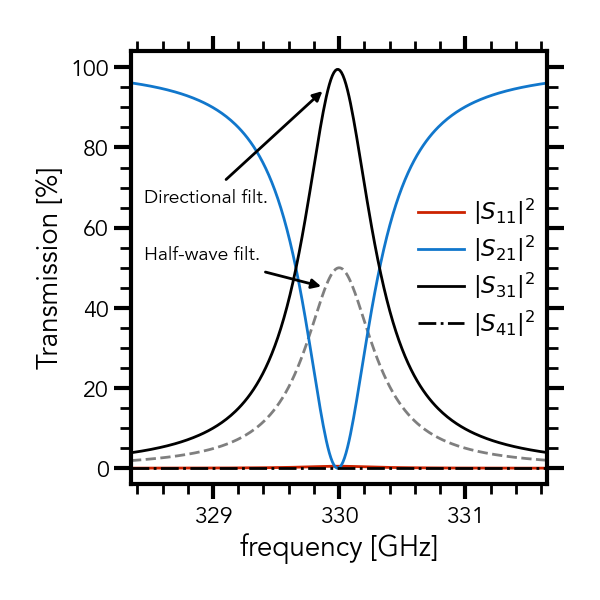

In [57]:
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot()

lines_MF = plotstep_add_S_params(f,single_filter_MF)
lines = lines_MF

lines_DF = plotstep_add_S_params(f,single_filter_DF)
labels = [r'$|S_{11}|^2$',r'$|S_{21}|^2$',r'$|S_{31}|^2$',r'$|S_{41}|^2$']
lines += lines_DF

lines_analytical = plotstep_add_analytical_model(f)
lines += lines_analytical

plotstep_percentage(lines)

color = ['#C20','#17C','#000','#C20','#17C','#000','#000','#C20','#17C','#000','#000']

for i,line in enumerate(lines):
    if i == 6:
        line.set_linestyle('-.')
    if i < 3:
        line.set_linestyle('--')
        line.set_alpha(0.5)
        if i < 2:
            line.set_linestyle('')
    line.set_color(color[i])
    if i > 6:
        line.set_marker("")
        line.set_linestyle("")
        line.set_markersize(3)
        line.set_markevery((0.05))
        


## ----------- ANNOTATIONS
ax.annotate("Directional filt.",xycoords='data',xy=(329.9,95),textcoords='axes fraction',xytext=(0.03,0.65),
            arrowprops=dict(arrowstyle="-|>", facecolor='black', connectionstyle="arc3"),fontsize='xx-small')
ax.annotate("Half-wave filt.",xycoords='data',xy=(329.9,45),textcoords='axes fraction',xytext=(0.03,0.55), va='top', ha='left',
            arrowprops=dict(arrowstyle="-|>", facecolor='black', connectionstyle="arc3"),fontsize='xx-small')



ax.set_xlabel('frequency [GHz]')  # Add an x-label to the axes.
ax.set_ylabel('Transmission [%]')  # Add a y-label to the axes.
ax.set_ylim(-4,104)
ax.set_xlim((f0_single-2.5*f0_single/500)/1e9,(f0_single+2.5*f0_single/500)/1e9)
legend = ax.legend(lines_DF,labels,loc="right",frameon=False,fontsize='x-small',handlelength=2,labelspacing=0.3,borderaxespad=0.1);  # Add a legend.
for legend_line in legend.get_lines():
    legend_line.set_linewidth(1)
savestr = fig_path + "single_filter_response.pdf"
fig.savefig(fname=savestr)
fig.set_tight_layout(True)
plt.show()

## Filterbank

meta NOT subset; don't know how to subset; dropped


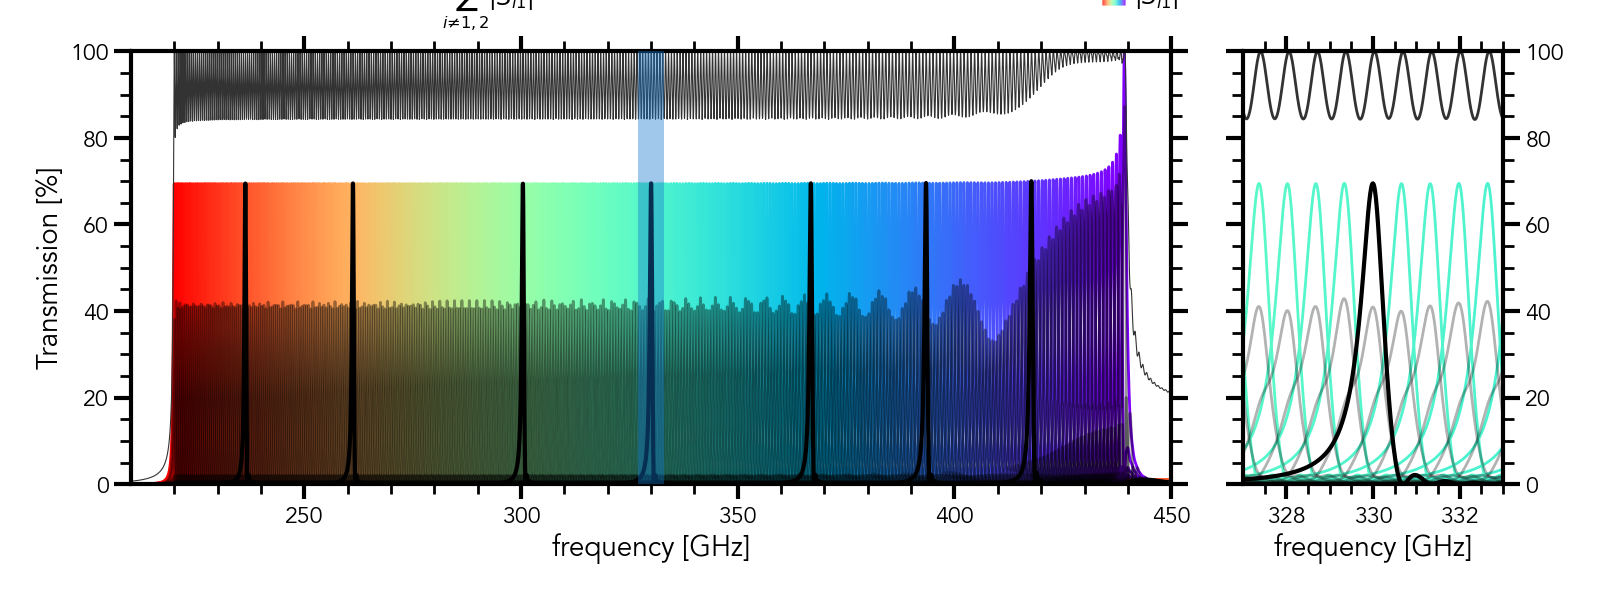

In [17]:
plt.close('all')
fig = plt.figure(figsize=(8,3))

plt.rcParams['lines.linewidth'] = 1
gs = fig.add_gridspec(1,2,width_ratios=[4,1])

##### Filterbank plot, comparison
ax = fig.add_subplot(gs[0, 0])

lines_DF = plotstep_add_filterbank(f,FB_DF_no_variance)
lines = lines_DF

lines_MF = plotstep_add_filterbank(f,FB_MF_no_variance)
lines += lines_MF

for line in lines_MF:
    line.set_color("black")
    line.set_alpha(0.4)
    line.set_linewidth(1)

# Sum of filters
sum_filters = np.sum(FB_DF_no_variance.S31_absSq_list,axis=0)
lines += ax.plot(f/1e9,sum_filters,color="0.2",linestyle="-",linewidth=0.4)


## highlight several individual filters
highlight_index = [25,55,90,143,190,260,310]
lines_highlight = []
for index in highlight_index:
    lines_highlight += ax.plot(f/1e9,FB_DF_no_variance.S31_absSq_list[index],color="0.0",linewidth=1.5)
lines += lines_highlight

# Make in percentage
plotstep_percentage(lines)


## Highlight zoom section
f_zoom = np.array([327e9,333e9])

left, bottom, width, height = (f_zoom[0]/1e9, 0, (f_zoom[1]-f_zoom[0])/1e9,100)
rect = plt.Rectangle((left, bottom), width, height, facecolor="#17C", alpha=0.4,zorder=1000)

ax.add_patch(rect)


ax.set_xlabel('frequency [GHz]')  # Add an x-label to the axes.
ax.set_ylabel('Transmission [%]')  # Add a y-label to the axes.
# ax.set_ylim(0,100)
ax.set_xlim(min(f)/1e9,max(f)/1e9)
# ax.set_title("Filter response")  # Add a title to the axes.
# ax.legend(lines_DF,labels,loc="right",frameon=False);  # Add a legend.
## ----------------------------------


##### zoom in on section of filterbank
ax_zoom = fig.add_subplot(gs[0, 1],sharey=ax)
ax_zoom.tick_params(labelleft=False,labelright=True)

lines_DF = plotstep_add_filterbank(f,FB_DF_no_variance)
lines = lines_DF

for line in lines_DF:
    line.set_linewidth(1)

lines_MF = plotstep_add_filterbank(f,FB_MF_no_variance)
lines += lines_MF

for line in lines_MF:
    line.set_color("black")
    line.set_alpha(0.3)
    line.set_linewidth(1)


# highlight a filter in zoom in
lines += ax_zoom.plot(f/1e9,FB_DF_no_variance.S31_absSq_list[highlight_index[3]],color="0.0",linewidth=1.5)

# Sum of filters
sum_filters = np.sum(FB_DF_no_variance.S31_absSq_list,axis=0)
lines += ax_zoom.plot(f/1e9,sum_filters,label=r"$\sum_{i \ne 1,2} |S_{i1}|^2$",color="0.2",linestyle="-",linewidth=1)

plotstep_percentage(lines)

ax_zoom.set_xlabel('frequency [GHz]')  # Add an x-label to the axes.
ax_zoom.set_xlim(f_zoom[0]/1e9,f_zoom[1]/1e9)
# ax_zoom.set_title("Filter response")  # Add a title to the axes.





n_colors = 30
cmap = cm.get_cmap('rainbow').copy()
rainbow_legend_colors = [cmap(x) for x in np.linspace(1,0,n_colors)]

# ------ get the legend-entries that are already attached to the figure
h, l = ax.get_legend_handles_labels()
h_zoom, l_zoom = ax_zoom.get_legend_handles_labels()

h += h_zoom
l += l_zoom

# ------ append the multicolor legend patches
h.append(MulticolorPatch(rainbow_legend_colors))
l.append(r"$|S_{i1}|^2$")

fig.legend(h, l, loc='upper left', bbox_to_anchor=(0.25, 1.05, 0.5, 0), handler_map={MulticolorPatch: MulticolorPatchHandler()},mode="expand", borderaxespad=0, ncol=3,fontsize='x-small', frameon=False)

# save and plot figure
savestr = fig_path + "filterbank_comparison.pdf"
fig.savefig(fname=savestr,bbox_inches="tight")
fig.subplots_adjust(top=0.5)

## Scatterplot of f0 and Ql

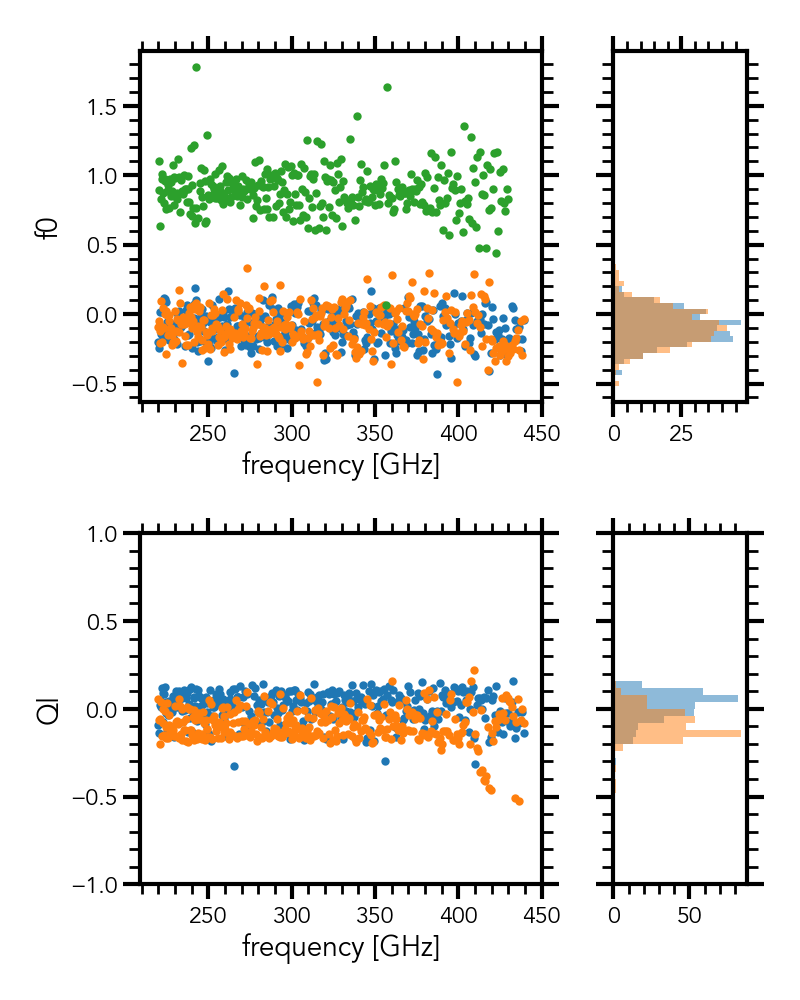

In [87]:
fig = plt.figure(figsize=(4,5))
gs = fig.add_gridspec(2,2,width_ratios=[3,1])

f0 = FB_DF_variance.f0
Ql = FB_DF_variance.Ql
f0_DF, Ql_DF, _, _, = FB_DF_variance.realized_parameters()
f0_MF, Ql_MF, _, _, = FB_MF_variance.realized_parameters()

data = np.genfromtxt("f_and_Q_scatter_LT263.csv",delimiter=",",comments="#")

f0_LT263_design = data[:,0] * 1e9
f0_LT263_df0 = (f0_LT263_design[1:] + f0_LT263_design[:-1]) / 2
f0_LT263 = data[:,1] * 1e9
Ql_LT263 = data[:,2]
# df_norm = f0_LT263_design/Ql
df_norm = f0_LT263_design[1:] - f0_LT263_design[:-1]
# df0_LT263 = (f0_LT263-f0_LT263_design)/df_norm
df0_LT263 = (f0_LT263[1:] - f0_LT263[:-1]) / df_norm
dQl_LT263 = (Ql_LT263-Ql) / Ql

df_norm = f0/Ql
df0_DF = (f0_DF-f0)/df_norm
df0_MF = (f0_MF-f0)/df_norm

dQl_DF = (Ql_DF-Ql)/Ql
dQl_MF = (Ql_MF-Ql)/Ql

# f0 --------------------------------------
ax = fig.add_subplot(gs[0,0])
ax.scatter(f0/1e9,df0_DF)
ax.scatter(f0/1e9,df0_MF)
ax.scatter(f0_LT263_df0/1e9,df0_LT263)
ax.set_xlabel('frequency [GHz]')  # Add an x-label to the axes.
ax.set_ylabel('f0')  # Add a y-label to the axes.
# ax.set_ylim(-1,1)

# t_DF = ax.text(0.1, 0.9, fr"DF: $\mu$ : {np.mean(df0_DF):.3f} $\sigma$ : {np.std(df0_DF):.3f}",
#             ha="left", va="center", size=10, transform=ax.transAxes,
#             bbox=dict(boxstyle="square,pad=0.3",
#                       fc="white", ec="grey", lw=1))
# t_MF = ax.text(0.1, 0.1, fr"MF: $\mu$ : {np.mean(df0_MF):.3f} $\sigma$ : {np.std(df0_MF):.3f}",
#             ha="left", va="center", size=10, transform=ax.transAxes,
#             bbox=dict(boxstyle="square,pad=0.3",
#                       fc="white", ec="grey", lw=1))

# Histogram
ax_hist = fig.add_subplot(gs[0,1],sharey=ax)

bins = make_bins_from_max(df0_DF,df0_MF,binwidth=0.04)
ax_hist.hist(df0_DF,orientation='horizontal',bins=bins,alpha=0.5)
ax_hist.hist(df0_MF,orientation='horizontal',bins=bins,alpha=0.5)
ax_hist.tick_params(labelleft=False)

# # Boxplot
# ax_boxplot = fig.add_subplot(gs[0,2],sharey=ax)

# bplot = ax_boxplot.boxplot([df0_DF,df0_MF],patch_artist=True,medianprops={"color":"C3","linewidth":2})
# ax_boxplot.yaxis.grid(True)
# ax_boxplot.set_xticks([1,2],labels=["DF","MF"])
# ax_boxplot.tick_params(labelleft=False)
# ax_boxplot.tick_params(axis="x",which="minor",length=0)

# colors = ["C0","C1"]
# for box_patch, color in zip(bplot["boxes"],colors):
#     box_patch.set_facecolor(color)
#     box_patch.set_alpha(0.5)

# # Violinplot
# ax_violinplot = fig.add_subplot(gs[0,3],sharey=ax)
# vplot = ax_violinplot.violinplot([df0_DF,df0_MF],showmedians=True)
# ax_violinplot.yaxis.grid(True)
# ax_violinplot.set_xticks([1,2],labels=["DF","MF"])
# ax_violinplot.tick_params(labelleft=False)
# ax_violinplot.tick_params(axis="x",which="minor",length=0)

# vplot["cmedians"].set_linewidth(2)
# vplot["cmedians"].set_color("C3")

# for violin_patch, color in zip(vplot["bodies"],colors):
#     violin_patch.set_facecolor(color)
#     violin_patch.set_alpha(0.5)


#----------------------------------------------------------------------


# Ql --------------------------------------
ax = fig.add_subplot(gs[1,0])
ax.scatter(f0/1e9,dQl_DF)
ax.scatter(f0/1e9,dQl_MF)
ax.set_xlabel('frequency [GHz]')  # Add an x-label to the axes.
ax.set_ylabel('Ql')  # Add a y-label to the axes.
ax.set_ylim(-1,1)

# t_DF = ax.text(0.1, 0.9, fr"DF: $\mu$ : {np.mean(dQl_DF):.3f} $\sigma$ : {np.std(dQl_DF):.3f}",
#             ha="left", va="center", size=10, transform=ax.transAxes,
#             bbox=dict(boxstyle="square,pad=0.3",
#                       fc="white", ec="grey", lw=1))
# t_MF = ax.text(0.1, 0.1, fr"MF: $\mu$ : {np.mean(dQl_MF):.3f} $\sigma$ : {np.std(dQl_MF):.3f}",
#             ha="left", va="center", size=10, transform=ax.transAxes,
#             bbox=dict(boxstyle="square,pad=0.3",
#                       fc="white", ec="grey", lw=1))

# Histogram
ax_hist = fig.add_subplot(gs[1,1],sharey=ax)

bins = make_bins_from_max(dQl_DF,dQl_MF,binwidth=0.04)
ax_hist.hist(dQl_DF,orientation='horizontal',bins=bins,alpha=0.5)
ax_hist.hist(dQl_MF,orientation='horizontal',bins=bins,alpha=0.5)

ax_hist.tick_params(labelleft=False)


# # Boxplot
# ax_boxplot = fig.add_subplot(gs[1,2],sharey=ax)

# bplot = ax_boxplot.boxplot([dQl_DF,dQl_MF],patch_artist=True,medianprops={"color":"C3","linewidth":2})
# ax_boxplot.yaxis.grid(True)
# ax_boxplot.set_xticks([1,2],labels=["DF","MF"])
# ax_boxplot.tick_params(labelleft=False)
# ax_boxplot.tick_params(axis="x",which="minor",length=0)

# colors = ["C0","C1"]
# for box_patch, color in zip(bplot["boxes"],colors):
#     box_patch.set_facecolor(color)
#     box_patch.set_alpha(0.5)

# # Violinplot
# ax_violinplot = fig.add_subplot(gs[1,3],sharey=ax)
# ax_violinplot.tick_params(labelleft=False)
# violinplot_pretty(ax_violinplot,[dQl_DF,dQl_MF],["DF","MF"])
# # ax.set_ybound(lower=0)
# # ax_hist.set_ylim(-0.7,0.3)

#-----------------------------------------------------------------------

Text(0, 0.5, 'variance [GHz]')

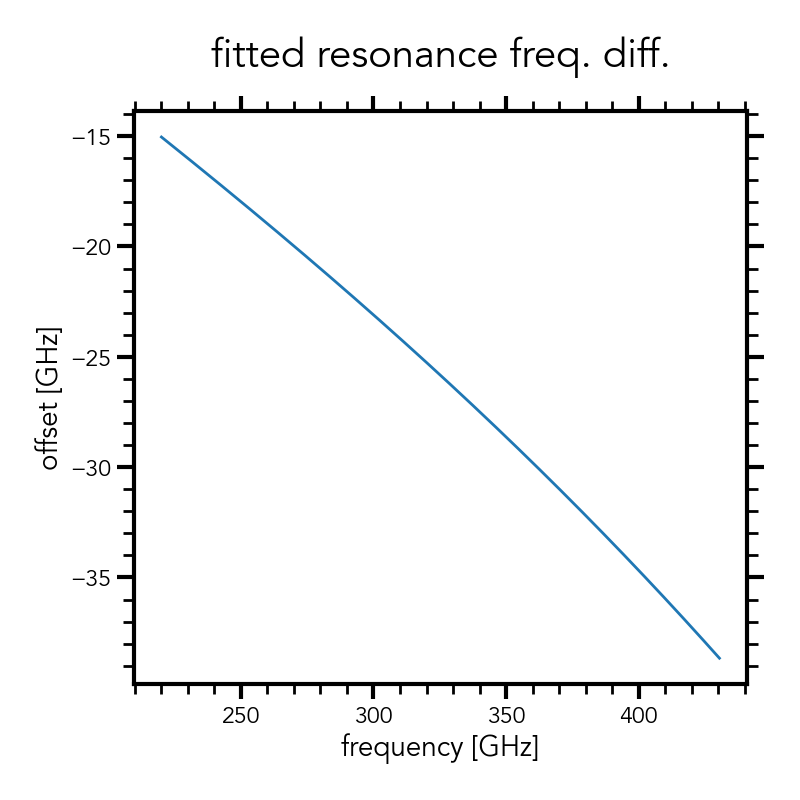

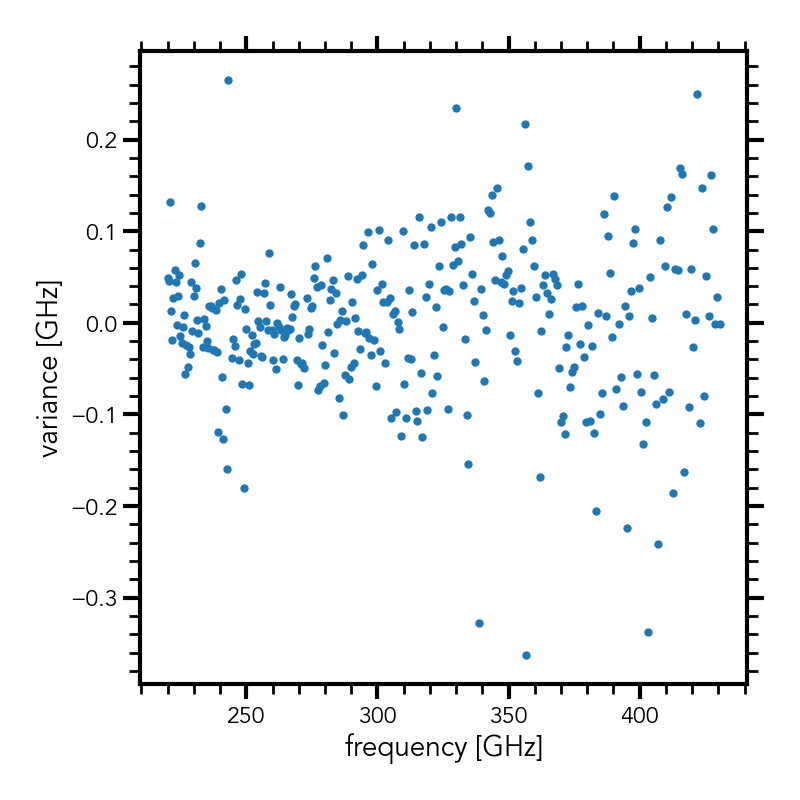

In [126]:
import numpy.polynomial.polynomial as poly



coefs = poly.polyfit(f0_LT263_design,f0_LT263,3)


fig = plt.figure(figsize=(4,4))
gs = fig.add_gridspec(1,1)
ax = fig.add_subplot(gs[0,0])


ax.plot(f0_LT263_design/1e9,(poly.polyval(f0_LT263_design,coefs) - f0_LT263_design)/1e9)


ax.set_title("fitted resonance freq. diff.")
ax.set_xlabel('frequency [GHz]')  # Add an x-label to the axes.
ax.set_ylabel('offset [GHz]')  # Add a y-label to the axes.


fig = plt.figure(figsize=(4,4))
gs = fig.add_gridspec(1,1)

ax = fig.add_subplot(gs[0,0])
ax.scatter(f0_LT263_design/1e9,((f0_LT263-f0_LT263_design)-(poly.polyval(f0_LT263_design,coefs) - f0_LT263_design))/1e9)

ax.set_title("")
ax.set_xlabel('frequency [GHz]')  # Add an x-label to the axes.
ax.set_ylabel('variance [GHz]')  # Add a y-label to the axes.

mean: 0.000
std: 0.122


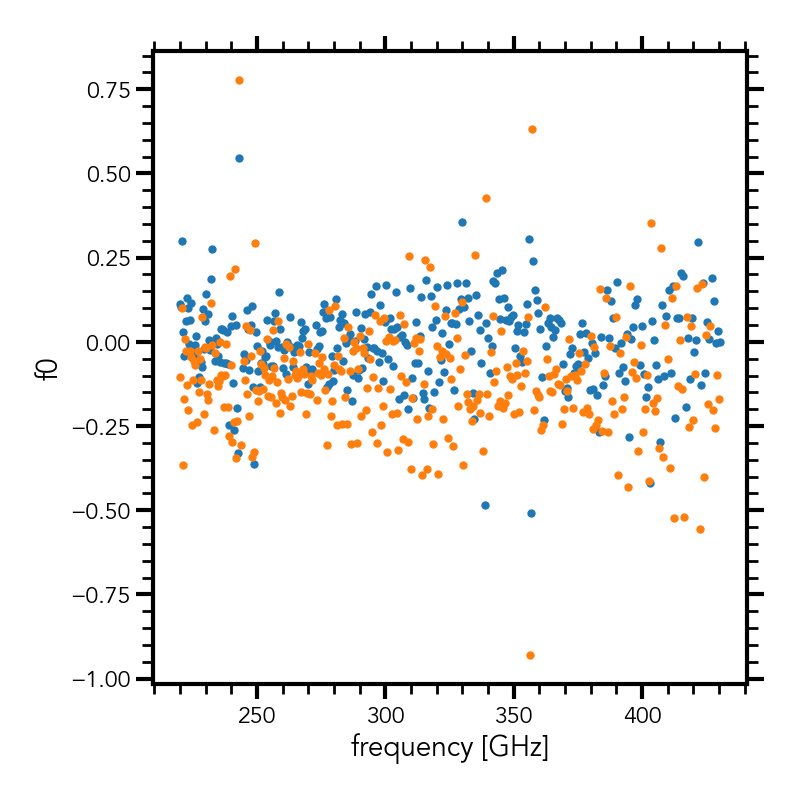

In [127]:

df_norm = f0_LT263_design/Ql
df0_LT263_normalized = (f0_LT263  - poly.polyval(f0_LT263_design,coefs)) / df_norm

df_diff_norm = f0_LT263_design[1:] - f0_LT263_design[:-1]
df0_LT263_diff = (f0_LT263[1:] - f0_LT263[:-1]) / df_diff_norm

fig = plt.figure(figsize=(4,4))
gs = fig.add_gridspec(1,1)

ax = fig.add_subplot(gs[0,0])
ax.scatter(f0_LT263_design/1e9,df0_LT263_normalized)
ax.scatter(f0_LT263_df0/1e9,df0_LT263_diff-1)


ax.set_xlabel('frequency [GHz]')  # Add an x-label to the axes.
ax.set_ylabel('f0')  # Add a y-label to the axes.

print(f'mean: {np.mean(df0_LT263_normalized):.3f}')
print(f'std: {np.std(df0_LT263_normalized):.3f}')

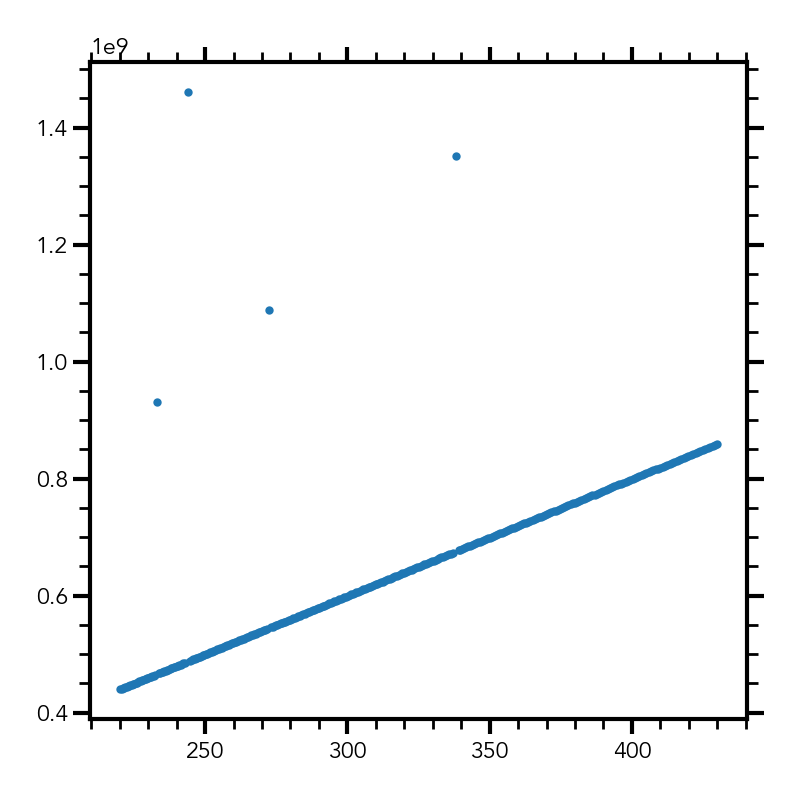

In [128]:
plt.figure()
plt.scatter(f0_LT263_df0/1e9,df_diff_norm)

## Grid Simulation of spectral resolution and oversampling

In [ ]:
nF = int(8e3)
f_sparse = np.linspace(210e9,450e9,nF)
os = np.array([0.8,0.9,1.,1.25,1.5,2.])

Rx_filter = np.flip(np.array([25, 300, 400, 500, 600])) # flip axis to 
Ry_spacing = np.outer(Rx_filter,os)
nRx = len(Rx_filter)
nRy = len(Ry_spacing.T)

f0_grid     = {}
f0_DF_grid  = {}
f0_MF_grid  = {}
Ql_DF_grid  = {}
Ql_MF_grid  = {}
eta_DF_grid = {}
eta_MF_grid = {}


for i, Rx in enumerate(Rx_filter):
    for j, Ry in enumerate(Ry_spacing[i,:]):
        FB_DF_variance.__init__(
            FilterClass=DirectionalFilter,
            TransmissionLines=TransmissionLinesLossyDict,
            f0_min=f0_min,
            f0_max=f0_max,
            Ql=Rx,
            oversampling=Ry/Rx,
            sigma_f0=sigma_f0 * (Rx/500),
            sigma_Qc=sigma_Qc,
            compensate=False
        )

        FB_MF_variance.__init__(
            FilterClass=ManifoldFilter,
            TransmissionLines=TransmissionLinesLossyDict,
            f0_min=f0_min,
            f0_max=f0_max,
            Ql=Rx,
            oversampling=Ry/Rx,
            sigma_f0=sigma_f0 * (Rx/500),
            sigma_Qc=sigma_Qc,
            compensate=False
        )

        FB_DF_variance.S(f)
        FB_MF_variance.S(f)

        f0_grid[i,j] = FB_DF_variance.f0

        f0_DF_grid[i,j], Ql_DF_grid[i,j], eta_DF_grid[i,j], _, = FB_DF_variance.realized_parameters()
        f0_MF_grid[i,j], Ql_MF_grid[i,j], eta_MF_grid[i,j], _, = FB_MF_variance.realized_parameters()


In [ ]:

fig_df0 = plt.figure(figsize=(10,10))
gs_df0 = fig_df0.add_gridspec(nRx,nRy)

fig_dQl = plt.figure(figsize=(10,10))
gs_dQl = fig_dQl.add_gridspec(nRx,nRy)

fig_eta = plt.figure(figsize=(16,16))
gs_eta = fig_eta.add_gridspec(nRx,nRy)

for i, Rx in enumerate(Rx_filter):
    for j, Ry in enumerate(Ry_spacing[i,:]):

        df_norm = f0_grid[i,j]/Rx
        df0_DF = (f0_DF_grid[i,j]-f0_grid[i,j])/df_norm
        df0_MF = (f0_MF_grid[i,j]-f0_grid[i,j])/df_norm

        dQl_DF = (Ql_DF_grid[i,j]-Rx)/Rx
        dQl_MF = (Ql_MF_grid[i,j]-Rx)/Rx
        
        ax_df0 = fig_df0.add_subplot(gs_df0[i,j])
        ax_dQl = fig_dQl.add_subplot(gs_dQl[i,j])
        ax_eta = fig_eta.add_subplot(gs_eta[i,j])

        ax_df0.scatter(f0_grid[i,j]/1e9,df0_DF)
        ax_df0.scatter(f0_grid[i,j]/1e9,df0_MF)
        ax_dQl.scatter(f0_grid[i,j]/1e9,dQl_DF)
        ax_dQl.scatter(f0_grid[i,j]/1e9,dQl_MF)
        ax_eta.scatter(f0_grid[i,j]/1e9,eta_DF_grid[i,j],label=f"Dir. Filt. ({np.median(eta_DF_grid[i,j]):.2f})")
        ax_eta.scatter(f0_grid[i,j]/1e9,eta_MF_grid[i,j],label=f"Man. Filt. ({np.median(eta_MF_grid[i,j]):.2f})")
        ax_eta.legend(loc="upper left")
        ax_eta.set_title(f"R_filt.: {Rx}\no.s.: {Ry/Rx}",size=12)
        

format_compact_grid(fig_df0)
format_compact_grid(fig_dQl)
format_compact_grid(fig_eta)

fig_df0.axes[0].set_ylim(-1,1)
fig_dQl.axes[0].set_ylim(-1,1)
fig_eta.axes[0].set_ylim(0,1)
    
    # For boxplot or violinplot
    # ax.tick_params(axis="x",which="minor",length=0)

plt.close(fig_df0)
plt.close(fig_dQl)

In [ ]:

fig_df0 = plt.figure(figsize=(10,10))
gs_df0 = fig_df0.add_gridspec(nRx,nRy)

fig_dQl = plt.figure(figsize=(10,10))
gs_dQl = fig_dQl.add_gridspec(nRx,nRy)

fig_eta = plt.figure(figsize=(12,12))
gs_eta = fig_eta.add_gridspec(nRx,nRy)

for i, Rx in enumerate(Rx_filter):
    for j, Ry in enumerate(Ry_spacing[i,:]):

        df_norm = f0_grid[i,j]/Rx
        df0_DF = (f0_DF_grid[i,j]-f0_grid[i,j])/df_norm
        df0_MF = (f0_MF_grid[i,j]-f0_grid[i,j])/df_norm

        dQl_DF = (Ql_DF_grid[i,j]-Rx)/Rx
        dQl_MF = (Ql_MF_grid[i,j]-Rx)/Rx
        
        ax_df0 = fig_df0.add_subplot(gs_df0[i,j])
        ax_dQl = fig_dQl.add_subplot(gs_dQl[i,j])
        ax_eta = fig_eta.add_subplot(gs_eta[i,j])

        violinlabels = ["DF","MF"]
        violinplot_pretty(ax_df0,[df0_DF,df0_MF],violinlabels)
        violinplot_pretty(ax_dQl,[dQl_DF,dQl_MF],violinlabels)
        violinplot_pretty(ax_eta,[eta_DF_grid[i,j],eta_MF_grid[i,j]],violinlabels)
        ax_eta.set_title(f"R_filt.: {Rx}\no.s.: {Ry/Rx}",size=8)


format_compact_grid(fig_df0)
format_compact_grid(fig_dQl)
format_compact_grid(fig_eta)

fig_df0.axes[0].set_ylim(-1,1)
fig_dQl.axes[0].set_ylim(-1,1)
fig_eta.axes[0].set_ylim(0,0.8)
    
    # For boxplot or violinplot
    # ax.tick_params(axis="x",which="minor",length=0)

# plt.close(fig_df0)
# plt.close(fig_dQl)

In [ ]:

fig_df0 = plt.figure(figsize=(5,5))
gs_df0 = fig_df0.add_gridspec(1,1)

fig_dQl = plt.figure(figsize=(5,5))
gs_dQl = fig_dQl.add_gridspec(1,1)

fig_eta = plt.figure(figsize=(5,5))
gs_eta = fig_eta.add_gridspec(1,1)

df0_DF_median = np.empty((nRx,nRy))
df0_MF_median = np.empty((nRx,nRy))
dQl_DF_median = np.empty((nRx,nRy))
dQl_MF_median = np.empty((nRx,nRy))
eta_DF_median = np.empty((nRx,nRy))
eta_MF_median = np.empty((nRx,nRy))

for i, Rx in enumerate(Rx_filter):
    for j, Ry in enumerate(Ry_spacing[i,:]):

        df_norm = f0_grid[i,j]/Rx
        df0_DF = (f0_DF_grid[i,j]-f0_grid[i,j])/df_norm
        df0_MF = (f0_MF_grid[i,j]-f0_grid[i,j])/df_norm

        dQl_DF = (Ql_DF_grid[i,j]-Rx)/Rx
        dQl_MF = (Ql_MF_grid[i,j]-Rx)/Rx

        df0_DF_median[i,j] = np.median(df0_DF)
        df0_MF_median[i,j] = np.median(df0_MF)
        dQl_DF_median[i,j] = np.median(dQl_DF)
        dQl_MF_median[i,j] = np.median(dQl_MF)
        eta_DF_median[i,j] = np.median(eta_DF_grid[i,j])
        eta_MF_median[i,j] = np.median(eta_MF_grid[i,j])


ax_df0 = fig_df0.add_subplot(gs_df0[0,0])
ax_dQl = fig_dQl.add_subplot(gs_dQl[0,0])
ax_eta = fig_eta.add_subplot(gs_eta[0,0])

for i, Rx in enumerate(Rx_filter):
    ax_df0.plot(os,df0_DF_median[i,:])
    ax_df0.plot(os,df0_MF_median[i,:])
    ax_dQl.plot(os,dQl_DF_median[i,:])
    ax_dQl.plot(os,dQl_MF_median[i,:])
    ax_eta.plot(os,eta_DF_median[i,:])
    ax_eta.plot(os,eta_MF_median[i,:])



fig_df0.axes[0].set_ylim(-1,1)
fig_dQl.axes[0].set_ylim(-1,1)
fig_eta.axes[0].set_ylim(0,1)
    
    # For boxplot or violinplot
    # ax.tick_params(axis="x",which="minor",length=0)

# plt.close(fig_df0)
# plt.close(fig_dQl)

In [ ]:

fig_df0 = plt.figure(figsize=(10,5))
gs_df0 = fig_df0.add_gridspec(1,2)

fig_dQl = plt.figure(figsize=(10,5))
gs_dQl = fig_dQl.add_gridspec(1,2)

fig_eta = plt.figure(figsize=(10,5))
gs_eta = fig_eta.add_gridspec(1,2)

df0_DF_median = np.empty((nRx,nRy))
df0_MF_median = np.empty((nRx,nRy))
dQl_DF_median = np.empty((nRx,nRy))
dQl_MF_median = np.empty((nRx,nRy))
eta_DF_median = np.empty((nRx,nRy))
eta_MF_median = np.empty((nRx,nRy))

for i, Rx in enumerate(Rx_filter):
    for j, Ry in enumerate(Ry_spacing[i,:]):

        df_norm = f0_grid[i,j]/Rx
        df0_DF = (f0_DF_grid[i,j]-f0_grid[i,j])/df_norm
        df0_MF = (f0_MF_grid[i,j]-f0_grid[i,j])/df_norm

        dQl_DF = (Ql_DF_grid[i,j]-Rx)/Rx
        dQl_MF = (Ql_MF_grid[i,j]-Rx)/Rx

        df0_DF_median[i,j] = np.median(df0_DF)
        df0_MF_median[i,j] = np.median(df0_MF)
        dQl_DF_median[i,j] = np.median(dQl_DF)
        dQl_MF_median[i,j] = np.median(dQl_MF)
        eta_DF_median[i,j] = np.median(eta_DF_grid[i,j])
        eta_MF_median[i,j] = np.median(eta_MF_grid[i,j])


ax_df0_DF = fig_df0.add_subplot(gs_df0[0,0],projection="3d")
ax_df0_MF = fig_df0.add_subplot(gs_df0[0,1],projection="3d")
ax_dQl_DF = fig_dQl.add_subplot(gs_dQl[0,0],projection="3d")
ax_dQl_MF = fig_dQl.add_subplot(gs_dQl[0,1],projection="3d")
ax_eta_DF = fig_eta.add_subplot(gs_eta[0,0],projection="3d")
ax_eta_MF = fig_eta.add_subplot(gs_eta[0,1],projection="3d")


ax_df0_DF.plot_surface(df0_DF_median)
ax_df0_MF.plot_surface(df0_MF_median)
ax_dQl_DF.plot_surface(dQl_DF_median)
ax_dQl_MF.plot_surface(dQl_MF_median)
ax_eta_DF.plot_surface(eta_DF_median)
ax_eta_MF.plot_surface(eta_MF_median)



# fig_df0.axes[0].set_ylim(-1,1)
# fig_dQl.axes[0].set_ylim(-1,1)
# fig_eta.axes[0].set_ylim(0,1)
    
    # For boxplot or violinplot
    # ax.tick_params(axis="x",which="minor",length=0)

# plt.close(fig_df0)
# plt.close(fig_dQl)